In [2]:
import pandas as  pd
import nibabel as nb
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from sklearn.ensemble import RandomForestClassifier
from sktree import ObliqueRandomForestClassifier
from tqdm import tqdm
from sklearn.model_selection import train_test_split

/Users/jayantadey/miniforge3/envs/cmi/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Load data

In [3]:
df = pd.read_excel('/Users/jayantadey/data_MRI/subjects_age_sex_data_MRI.xlsx')
df.head()

,ID,Age,Sex,Dataset,Dataset-ID
0,sub-ABIDE1050339,18.0000,MALE,ABIDE,50339
1,sub-ABIDE1050701,18.0000,MALE,ABIDE,50701
2,sub-ABIDE1050445,18.1383,MALE,ABIDE,50445
3,sub-ABIDE1050459,18.1547,MALE,ABIDE,50459
4,sub-ABIDE1050341,18.2000,FEMALE,ABIDE,50341


### Load the mask

In [4]:
mask = nb.load('/Users/jayantadey/data_MRI/template_cat12/brainmask.nii').get_fdata()

Text(0.5, 1.0, 'Mask (Traverse)')

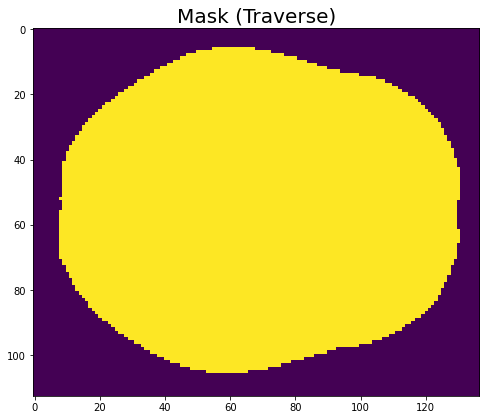

In [5]:
slice=50
sliced_img = mask[:,:,slice]

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.imshow(sliced_img)

ax.set_title('Mask (Traverse)', fontsize=20)

In [6]:
idx = np.where(mask.reshape(-1)>0)[0]

### Load data and build (feature, label)

In [7]:
path = '/Users/jayantadey/data_MRI/'
subjects = os.listdir(path)
X = []
y = []
IDs = set(df['ID'])
for subject in subjects:
    if subject in IDs:
        #print(df[df['ID']==subject]['Sex'])
        sex = int(df[df['ID']==subject]['Sex'].item()=='FEMALE')
        current_file = os.path.join(path, subject)
        tmp = []
        save = True
        for file in glob.glob(current_file+'/mri/*'):
            try:
                img = nb.load(file).get_fdata()
                #print(img.shape)
                tmp.append(img.reshape(-1)[idx])
            except:
                save = False
                print(file,' corrupted')

        '''if len(tmp)<2:
            print(subject, ' has less files')'''
            
        if save and len(tmp)==2:
            X.append(np.array(tmp).reshape(1,-1))
            y.append(sex)
    
X = np.concatenate(X,axis=0)

### Random Forest after applying mask

In [40]:
reps = 5
accuracy = 0.0

for _ in tqdm(range(reps)):
    x_train, x_test, y_train, y_test = train_test_split(
                    X, y, train_size=0.6, random_state=0, stratify=y)
    clf = RandomForestClassifier(n_estimators=1000)
    clf.fit(x_train,y_train)
    accuracy += np.mean(clf.predict(x_test)==y_test)

print('Accuracy is ',accuracy/reps)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [1:23:06<00:00, 997.35s/it]

Accuracy is  0.8029535864978902


In [56]:
slice = 50
demo_filepath_whitematter = '/Users/jayantadey/data_MRI/sub-A00008326/mri/mwp2sub-A00008326_T1w.nii'
demo_filepath_graymatter = '/Users/jayantadey/data_MRI/sub-A00008326/mri/mwp1sub-A00008326_T1w.nii'

img_whitematter = nb.load(demo_filepath_whitematter).get_fdata()
sliced_img_whitematter = img_whitematter[:,:,slice]

img_graymatter = nb.load(demo_filepath_graymatter).get_fdata()
sliced_img_graymatter = img_graymatter[:,:,slice]

In [75]:
clf_rf_importance_map = clf.feature_importances_/np.max(clf.feature_importances_)

In [76]:
brain_img = 0*np.ones((113*137*113), dtype=float)
brain_img[idx] = clf_sporf_importance_map[:len(idx)]
brain_img = brain_img.reshape(113,137,113)

Text(0.5, 1.0, 'White matter (Traverse)')

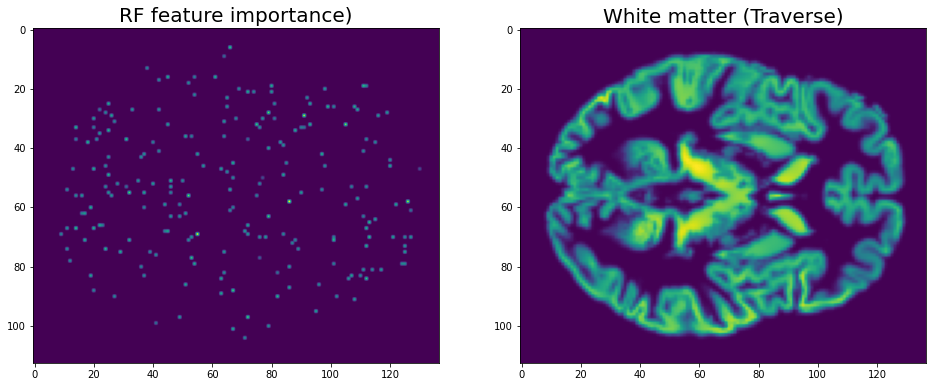

In [77]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].imshow(brain_img[:,:,50]**.2)
ax[1].imshow(sliced_img_graymatter)

ax[0].set_title('RF feature importance)', fontsize=20)
ax[1].set_title('White matter (Traverse)', fontsize=20)

### Try SPORF

In [10]:
reps = 5
accuracy = 0.0

for _ in tqdm(range(reps)):
    x_train, x_test, y_train, y_test = train_test_split(
                    X, y, train_size=0.6, random_state=0, stratify=y)
    clf_sporf = ObliqueRandomForestClassifier(n_estimators=100, max_features=20)
    clf_sporf.fit(x_train,y_train)
    accuracy += np.mean(clf_sporf.predict(x_test)==y_test)

print('Accuracy is ',accuracy/reps)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [4:05:39<00:00, 2947.92s/it]

Accuracy is  0.7710970464135021


In [72]:
clf_sporf_importance_map = clf_sporf.feature_importances_/np.max(clf_sporf.feature_importances_)

In [73]:
brain_img = 0*np.ones((113*137*113), dtype=float)
brain_img[idx] = clf_sporf_importance_map[:len(idx)]
brain_img = brain_img.reshape(113,137,113)

Text(0.5, 1.0, 'Gray matter (Traverse)')

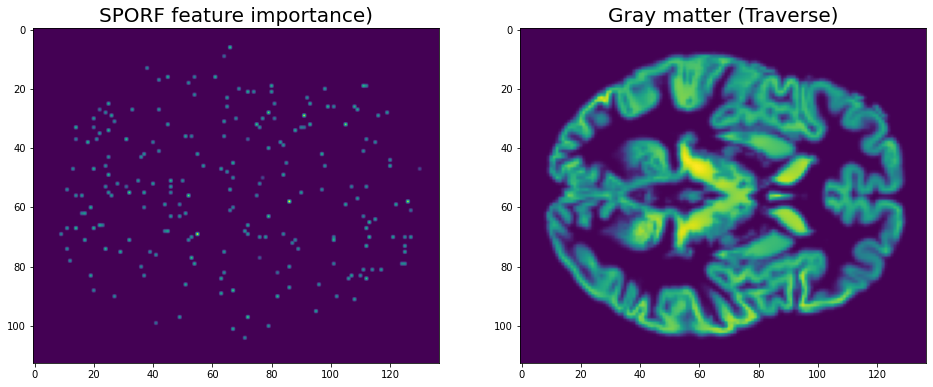

In [74]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].imshow(brain_img[:,:,50]**.2)
ax[1].imshow(sliced_img_graymatter)

ax[0].set_title('SPORF feature importance)', fontsize=20)
ax[1].set_title('Gray matter (Traverse)', fontsize=20)

### Propensity score matching (https://cran.r-project.org/web/packages/MatchIt/vignettes/MatchIt.html)

1. Consider male sex as control group: Y=0 and female sex as the treated group: Y=1
2. Calculate propensity score for age (A): P(Y=1|A)
3. Match each male with the closest female using 1-NN on the propensity score and take the difference in the feature matrix
4. Match each male with the closest male using 1-NN on the propensity score and take the difference in the feature matrix
5. Classify both the feature matrix differences with the labels: effect (1) and no-effect (0)


### Todos
1. plot rank 
2. run morf, threshold feature importance with respect to random label and set to 1, then plot
